In [ ]:
!pip3 install bitarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 236 kB 4.3 MB/s 


In [ ]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.1 MB/s 


In [ ]:
from struct import unpack
from tkinter import *
from bitarray import bitarray
from bitarray.util import int2ba
from PIL import Image
from scipy.fftpack import dct
from tqdm import tqdm
from skimage.metrics import structural_similarity
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import string
import random
import lpips
import torch
import os

In [ ]:
start_time = time.time()

In [ ]:
os.environ['PYTHONHASHSEED']=str(456)
np.random.seed(456)
random.seed(456)

In [ ]:
images = []

for fileName in tqdm(os.listdir('dataset/')):
  img = Image.open('dataset/' + fileName)
  images.append(img)

100%|██████████| 4881/4881 [00:00<00:00, 9794.00it/s] 


In [ ]:
len(images)

4881

In [ ]:
imagesYCbCr = []

for img in tqdm(images):
  imgYCbCr = img.convert('YCbCr')
  imagesYCbCr.append(imgYCbCr)

100%|██████████| 4881/4881 [00:01<00:00, 3604.80it/s]


In [ ]:
imagesArray = []

for imgYCbCr in tqdm(imagesYCbCr):
  imgArray = np.asarray(imgYCbCr, dtype='int32')

  if imgArray.shape[2] != 3:
    continue

  imagesArray.append(imgArray)

100%|██████████| 4881/4881 [00:00<00:00, 18571.75it/s]


In [ ]:
imagesArrayPad = []

for imgArray in tqdm(imagesArray):
  dimX = imgArray.shape[0]
  dimY = imgArray.shape[1]
  nCanais = imgArray.shape[2]

  padX = (8 - (dimX % 8)) % 8
  padY = (8 - (dimY % 8)) % 8

  imgArrayPad = np.pad(imgArray, ((0, padX), (0, padY), (0, 0)), 'edge')
  imagesArrayPad.append(imgArrayPad)

100%|██████████| 4881/4881 [00:00<00:00, 8648.77it/s]


In [ ]:
bytes_por_imagem = []
espaco_bits_mensagem_secreta = []
espaco_bytes_mensagem_secreta = []

for imgArrayPad in tqdm(imagesArrayPad):
  x1 = imgArrayPad.shape[0] * imgArrayPad.shape[1]
  x2 = x1 // 64

  bytes_por_imagem.append(x1)
  espaco_bits_mensagem_secreta.append(x2)
  espaco_bytes_mensagem_secreta.append(x2 // 8)

100%|██████████| 4881/4881 [00:00<00:00, 843005.88it/s]


In [ ]:
mensagens_secreta = []

for tamanho in tqdm(espaco_bytes_mensagem_secreta):
  mensagem = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(tamanho))
  mensagens_secreta.append(mensagem)

100%|██████████| 4881/4881 [00:00<00:00, 89396.77it/s]


In [ ]:
lista_bitarray_mensagem = []

for mensagem in tqdm(mensagens_secreta):
  bitarray_mensagem = bitarray()
  
  for caracter in mensagem:
    bitarray_mensagem += int2ba(ord(caracter), length=8)

  lista_bitarray_mensagem.append(bitarray_mensagem)

100%|██████████| 4881/4881 [00:00<00:00, 36042.00it/s]


In [ ]:
for i in tqdm(range(len(imagesArrayPad))):
  imagesArrayPad[i] -= 128

100%|██████████| 4881/4881 [00:00<00:00, 91300.48it/s]


In [ ]:
comprimentoX = []
comprimentoY = []

for imgArrayPad in tqdm(imagesArrayPad):
  comprimentoX.append(imgArrayPad.shape[0])
  comprimentoY.append(imgArrayPad.shape[1])

100%|██████████| 4881/4881 [00:00<00:00, 1226847.12it/s]


In [ ]:
listaMatY = []
listaMatCb = []
listaMatCr = []

for imgArrayPad in tqdm(imagesArrayPad):
  matY, matCb, matCr  = imgArrayPad[:,:,0], imgArrayPad[:,:,1], imgArrayPad[:,:,2]

  listaMatY.append(matY)
  listaMatCb.append(matCb)
  listaMatCr.append(matCr)

100%|██████████| 4881/4881 [00:00<00:00, 514007.33it/s]


In [ ]:
listaBlocosY = []
listaBlocosCb = []
listaBlocosCr = []

for z in tqdm(range(len(listaMatY))):
  blocosY = []
  blocosCb = []
  blocosCr = []

  for i in range(0, comprimentoX[z], 8):
      for j in range(0, comprimentoY[z], 8):
          blocosY.append(listaMatY[z][i:i+8, j:j+8])
          blocosCb.append(listaMatCb[z][i:i+8, j:j+8])
          blocosCr.append(listaMatCr[z][i:i+8, j:j+8])
          
  blocosY = np.array(blocosY)
  blocosCb = np.array(blocosCb)
  blocosCr = np.array(blocosCr)

  listaBlocosY.append(blocosY)
  listaBlocosCb.append(blocosCb)
  listaBlocosCr.append(blocosCr)

100%|██████████| 4881/4881 [00:01<00:00, 3786.13it/s]


In [ ]:
def dct2(x):
    m0 = 2.0 * math.cos(1.0 / 16.0 * 2.0 * math.pi)
    m1 = 2.0 * math.cos(2.0 / 16.0 * 2.0 * math.pi)
    m3 = 2.0 * math.cos(2.0 / 16.0 * 2.0 * math.pi)
    m5 = 2.0 * math.cos(3.0 / 16.0 * 2.0 * math.pi)
    m2 = m0 - m5
    m4 = m0 + m5
    
    s0 = math.cos(0.0 / 16.0 * math.pi) / math.sqrt(8)
    s1 = math.cos(1.0 / 16.0 * math.pi) / 2.0
    s2 = math.cos(2.0 / 16.0 * math.pi) / 2.0
    s3 = math.cos(3.0 / 16.0 * math.pi) / 2.0
    s4 = math.cos(4.0 / 16.0 * math.pi) / 2.0
    s5 = math.cos(5.0 / 16.0 * math.pi) / 2.0
    s6 = math.cos(6.0 / 16.0 * math.pi) / 2.0
    s7 = math.cos(7.0 / 16.0 * math.pi) / 2.0
    
    for i in range(8):
        a0 = x[0][i]
        a1 = x[1][i]
        a2 = x[2][i]
        a3 = x[3][i]
        a4 = x[4][i]
        a5 = x[5][i]
        a6 = x[6][i]
        a7 = x[7][i]

        b0 = a0 + a7
        b1 = a1 + a6
        b2 = a2 + a5
        b3 = a3 + a4
        b4 = a3 - a4
        b5 = a2 - a5
        b6 = a1 - a6
        b7 = a0 - a7

        c0 = b0 + b3
        c1 = b1 + b2
        c2 = b1 - b2
        c3 = b0 - b3
        c4 = b4
        c5 = b5 - b4
        c6 = b6 - c5
        c7 = b7 - b6

        d0 = c0 + c1
        d1 = c0 - c1
        d2 = c2
        d3 = c3 - c2
        d4 = c4
        d5 = c5
        d6 = c6
        d7 = c5 + c7
        d8 = c4 - c6

        e0 = d0
        e1 = d1
        e2 = d2 * m1
        e3 = d3
        e4 = d4 * m2
        e5 = d5 * m3
        e6 = d6 * m4
        e7 = d7
        e8 = d8 * m5

        f0 = e0
        f1 = e1
        f2 = e2 + e3
        f3 = e3 - e2
        f4 = e4 + e8
        f5 = e5 + e7
        f6 = e6 + e8
        f7 = e7 - e5

        g0 = f0
        g1 = f1
        g2 = f2
        g3 = f3
        g4 = f4 + f7
        g5 = f5 + f6
        g6 = f5 - f6
        g7 = f7 - f4

        x[0][i] = g0 * s0
        x[4][i] = g1 * s4
        x[2][i] = g2 * s2
        x[6][i] = g3 * s6
        x[5][i] = g4 * s5
        x[1][i] = g5 * s1
        x[7][i] = g6 * s7
        x[3][i] = g7 * s3
        
    for i in range(8):
        a0 = x[i][0]
        a1 = x[i][1]
        a2 = x[i][2]
        a3 = x[i][3]
        a4 = x[i][4]
        a5 = x[i][5]
        a6 = x[i][6]
        a7 = x[i][7]

        b0 = a0 + a7
        b1 = a1 + a6
        b2 = a2 + a5
        b3 = a3 + a4
        b4 = a3 - a4
        b5 = a2 - a5
        b6 = a1 - a6
        b7 = a0 - a7

        c0 = b0 + b3
        c1 = b1 + b2
        c2 = b1 - b2
        c3 = b0 - b3
        c4 = b4
        c5 = b5 - b4
        c6 = b6 - c5
        c7 = b7 - b6

        d0 = c0 + c1
        d1 = c0 - c1
        d2 = c2
        d3 = c3 - c2
        d4 = c4
        d5 = c5
        d6 = c6
        d7 = c5 + c7
        d8 = c4 - c6

        e0 = d0
        e1 = d1
        e2 = d2 * m1
        e3 = d3
        e4 = d4 * m2
        e5 = d5 * m3
        e6 = d6 * m4
        e7 = d7
        e8 = d8 * m5

        f0 = e0
        f1 = e1
        f2 = e2 + e3
        f3 = e3 - e2
        f4 = e4 + e8
        f5 = e5 + e7
        f6 = e6 + e8
        f7 = e7 - e5

        g0 = f0
        g1 = f1
        g2 = f2
        g3 = f3
        g4 = f4 + f7
        g5 = f5 + f6
        g6 = f5 - f6
        g7 = f7 - f4

        x[i][0] = g0 * s0
        x[i][4] = g1 * s4
        x[i][2] = g2 * s2
        x[i][6] = g3 * s6
        x[i][5] = g4 * s5
        x[i][1] = g5 * s1
        x[i][7] = g6 * s7
        x[i][3] = g7 * s3
        
    return x

In [ ]:
listaDctsY = []
listaDctsCb = []
listaDctsCr = []

for z in tqdm(range(len(listaBlocosY))):
  dctsY = []
  dctsCb = []
  dctsCr = []

  for i in range(listaBlocosY[z].shape[0]):
      dctsY.append(dct2(listaBlocosY[z][i]))
      dctsCb.append(dct2(listaBlocosCb[z][i]))
      dctsCr.append(dct2(listaBlocosCr[z][i]))
      
  dctsY = np.array(dctsY)
  dctsCb = np.array(dctsCb)
  dctsCr = np.array(dctsCr)

  listaDctsY.append(dctsY)
  listaDctsCb.append(dctsCb)
  listaDctsCr.append(dctsCr)

100%|██████████| 4881/4881 [07:13<00:00, 11.26it/s]


In [ ]:
fatorDeQualidade = 90

s = 5000 / fatorDeQualidade

if fatorDeQualidade >= 50:
    s = 200 - (2 * fatorDeQualidade)

In [ ]:
matrizQuantizacaoPredefinidaLuminancia = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ]
)

matrizQuantizacaoPredefinidaCrominancia = np.array(
    [
        [17, 18, 24, 47, 99, 99, 99, 99],
        [18, 21, 26, 66, 99, 99, 99, 99],
        [24, 26, 56, 99, 99, 99, 99, 99],
        [47, 66, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99]
    ]
)

In [ ]:
matrizQuantizacaoLuminancia = np.ones((8, 8))
matrizQuantizacaoCrominancia = np.ones((8, 8))

In [ ]:
for i in range(8):
    for j in range(8):
        matrizQuantizacaoLuminancia[i][j] = math.floor((s * matrizQuantizacaoPredefinidaLuminancia[i][j] + 50) / 100)
        matrizQuantizacaoCrominancia[i][j] = math.floor((s * matrizQuantizacaoPredefinidaCrominancia[i][j] + 50) / 100)

In [ ]:
listaCoeficientesQuantizadosY = []
listaCoeficientesQuantizadosCb = []
listaCoeficientesQuantizadosCr = []

for z in tqdm(range(len(listaDctsY))):
  coeficientesQuatizadosY = []
  coeficientesQuatizadosCb = []
  coeficientesQuatizadosCr = []

  for i in range(listaDctsY[z].shape[0]):
      coeficientesQuatizadosY.append(listaDctsY[z][i] // matrizQuantizacaoLuminancia)
      coeficientesQuatizadosCb.append(listaDctsCb[z][i] // matrizQuantizacaoCrominancia)
      coeficientesQuatizadosCr.append(listaDctsCr[z][i] // matrizQuantizacaoCrominancia)
      
  coeficientesQuatizadosY = np.array(coeficientesQuatizadosY)
  coeficientesQuatizadosCb = np.array(coeficientesQuatizadosCb)
  coeficientesQuatizadosCr = np.array(coeficientesQuatizadosCr)

  listaCoeficientesQuantizadosY.append(coeficientesQuatizadosY)
  listaCoeficientesQuantizadosCb.append(coeficientesQuatizadosCb)
  listaCoeficientesQuantizadosCr.append(coeficientesQuatizadosCr)

100%|██████████| 4881/4881 [00:04<00:00, 1066.03it/s]


In [ ]:
matrizZigzag = [
            [0, 1, 5, 6, 14, 15, 27, 28],
            [2, 4, 7, 13, 16, 26, 29, 42],
            [3, 8, 12, 17, 25, 30, 41, 43],
            [9, 11, 18, 24, 31, 40, 44, 53],
            [10, 19, 23, 32, 39, 45, 52, 54],
            [20, 22, 33, 38, 46, 51, 55, 60],
            [21, 34, 37, 47, 50, 56, 59, 61],
            [35, 36, 48, 49, 57, 58, 62, 63],
        ]

In [ ]:
listaArrayY = []
listaArrayCb = []
listaArrayCr = []

for z in tqdm(range(len(listaCoeficientesQuantizadosY))):
  arrayY = []
  arrayCb = []
  arrayCr = []

  for k in range(listaCoeficientesQuantizadosY[z].shape[0]):
      tY = np.zeros(64)
      tCb = np.zeros(64)
      tCr = np.zeros(64)
      
      for i in range(8):
          for j in range(8):
              tY[matrizZigzag[i][j]] = listaCoeficientesQuantizadosY[z][k][i][j]
              tCb[matrizZigzag[i][j]] = listaCoeficientesQuantizadosCb[z][k][i][j]
              tCr[matrizZigzag[i][j]] = listaCoeficientesQuantizadosCr[z][k][i][j]
      
      arrayY.append(tY)
      arrayCb.append(tCb)
      arrayCr.append(tCr)
      
  arrayY = np.array(arrayY)
  arrayCb = np.array(arrayCb)
  arrayCr = np.array(arrayCr)

  listaArrayY.append(arrayY)
  listaArrayCb.append(arrayCb)
  listaArrayCr.append(arrayCr)

100%|██████████| 4881/4881 [00:43<00:00, 111.84it/s]


In [ ]:
for z in tqdm(range(len(listaArrayY))):
  for i in reversed(range(1, listaArrayY[z].shape[0])):
      listaArrayY[z][i][0] -= listaArrayY[z][i-1][0]
      listaArrayCb[z][i][0] -= listaArrayCb[z][i-1][0]
      listaArrayCr[z][i][0] -= listaArrayCr[z][i-1][0]

100%|██████████| 4881/4881 [00:00<00:00, 5918.43it/s]


In [ ]:
def armazena_steganografia_no_byte(valor_byte, valor_stegano1):
  valor_byte = int(valor_byte)

  if valor_stegano1 == 1:
    valor_byte |= 1
  else:
    valor_byte &= (~1)

  return valor_byte

In [ ]:
for z in tqdm(range(len(listaArrayY))):
  contador_bit_esteganografia = 0

  for i in range(listaArrayY[z].shape[0]):
      if contador_bit_esteganografia < len(lista_bitarray_mensagem[z]):
        listaArrayCb[z][i][1] = armazena_steganografia_no_byte(listaArrayCb[z][i][1], lista_bitarray_mensagem[z][contador_bit_esteganografia])

      contador_bit_esteganografia += 1

100%|██████████| 4881/4881 [00:00<00:00, 10717.28it/s]


In [ ]:
huffmanDCLuminancia = {
    "tamanho": [0, 1, 5, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    "valores": [0x00, 0x01, 0x02, 0x03, 0x04, 0x05, 0x06, 0x07, 0x08, 0x09, 0x0a, 0x0b]
}

In [ ]:
huffmanDCCrominancia = {
    "tamanho": [0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    "valores": [0x00, 0x01, 0x02, 0x03, 0x04, 0x05, 0x06, 0x07, 0x08, 0x09, 0x0a, 0x0b]
}

In [ ]:
huffmanACLuminancia = {
    "tamanho": [0, 2, 1, 3, 3, 2, 4, 3, 5, 5, 4, 4, 0, 0, 1, 125],
    "valores": [0x01, 0x02, 0x03, 0x00, 0x04, 0x11, 0x05, 0x12,
        0x21, 0x31, 0x41, 0x06, 0x13, 0x51, 0x61, 0x07,
        0x22, 0x71, 0x14, 0x32, 0x81, 0x91, 0xa1, 0x08,
        0x23, 0x42, 0xb1, 0xc1, 0x15, 0x52, 0xd1, 0xf0,
        0x24, 0x33, 0x62, 0x72, 0x82, 0x09, 0x0a, 0x16,
        0x17, 0x18, 0x19, 0x1a, 0x25, 0x26, 0x27, 0x28,
        0x29, 0x2a, 0x34, 0x35, 0x36, 0x37, 0x38, 0x39,
        0x3a, 0x43, 0x44, 0x45, 0x46, 0x47, 0x48, 0x49,
        0x4a, 0x53, 0x54, 0x55, 0x56, 0x57, 0x58, 0x59,
        0x5a, 0x63, 0x64, 0x65, 0x66, 0x67, 0x68, 0x69,
        0x6a, 0x73, 0x74, 0x75, 0x76, 0x77, 0x78, 0x79,
        0x7a, 0x83, 0x84, 0x85, 0x86, 0x87, 0x88, 0x89,
        0x8a, 0x92, 0x93, 0x94, 0x95, 0x96, 0x97, 0x98,
        0x99, 0x9a, 0xa2, 0xa3, 0xa4, 0xa5, 0xa6, 0xa7,
        0xa8, 0xa9, 0xaa, 0xb2, 0xb3, 0xb4, 0xb5, 0xb6,
        0xb7, 0xb8, 0xb9, 0xba, 0xc2, 0xc3, 0xc4, 0xc5,
        0xc6, 0xc7, 0xc8, 0xc9, 0xca, 0xd2, 0xd3, 0xd4,
        0xd5, 0xd6, 0xd7, 0xd8, 0xd9, 0xda, 0xe1, 0xe2,
        0xe3, 0xe4, 0xe5, 0xe6, 0xe7, 0xe8, 0xe9, 0xea,
        0xf1, 0xf2, 0xf3, 0xf4, 0xf5, 0xf6, 0xf7, 0xf8,
        0xf9, 0xfa]
}

In [ ]:
huffmanACCrominancia = {
    "tamanho": [0, 2, 1, 2, 4, 4, 3, 4, 7, 5, 4, 4, 0, 1, 2, 119],
    "valores": [0x00, 0x01, 0x02, 0x03, 0x11, 0x04, 0x05, 0x21,
        0x31, 0x06, 0x12, 0x41, 0x51, 0x07, 0x61, 0x71,
        0x13, 0x22, 0x32, 0x81, 0x08, 0x14, 0x42, 0x91,
        0xa1, 0xb1, 0xc1, 0x09, 0x23, 0x33, 0x52, 0xf0,
        0x15, 0x62, 0x72, 0xd1, 0x0a, 0x16, 0x24, 0x34,
        0xe1, 0x25, 0xf1, 0x17, 0x18, 0x19, 0x1a, 0x26,
        0x27, 0x28, 0x29, 0x2a, 0x35, 0x36, 0x37, 0x38,
        0x39, 0x3a, 0x43, 0x44, 0x45, 0x46, 0x47, 0x48,
        0x49, 0x4a, 0x53, 0x54, 0x55, 0x56, 0x57, 0x58,
        0x59, 0x5a, 0x63, 0x64, 0x65, 0x66, 0x67, 0x68,
        0x69, 0x6a, 0x73, 0x74, 0x75, 0x76, 0x77, 0x78,
        0x79, 0x7a, 0x82, 0x83, 0x84, 0x85, 0x86, 0x87,
        0x88, 0x89, 0x8a, 0x92, 0x93, 0x94, 0x95, 0x96,
        0x97, 0x98, 0x99, 0x9a, 0xa2, 0xa3, 0xa4, 0xa5,
        0xa6, 0xa7, 0xa8, 0xa9, 0xaa, 0xb2, 0xb3, 0xb4,
        0xb5, 0xb6, 0xb7, 0xb8, 0xb9, 0xba, 0xc2, 0xc3,
        0xc4, 0xc5, 0xc6, 0xc7, 0xc8, 0xc9, 0xca, 0xd2,
        0xd3, 0xd4, 0xd5, 0xd6, 0xd7, 0xd8, 0xd9, 0xda,
        0xe2, 0xe3, 0xe4, 0xe5, 0xe6, 0xe7, 0xe8, 0xe9,
        0xea, 0xf2, 0xf3, 0xf4, 0xf5, 0xf6, 0xf7, 0xf8,
        0xf9, 0xfa]
}

In [ ]:
def intParaStringBits(x, length):
    ret = ""
    
    flag = False
    
    if x < 0:
        x *= -1
        flag = True
    
    for i in range(length):
        if x & 1 == 1:
            if flag == True:
                ret += "0"
            else:
                ret += "1"
        else:
            if flag == True:
                ret += "1"
            else:
                ret += "0"
            
        x = x >> 1
        
    return ret[::-1]

In [ ]:
def somaUm(x):
    x = x[::-1]
    
    y = ""
    flag = False
    
    for i in range(len(x)):
        if flag == False:
            if x[i] == "0":
                y += "1"
                flag = True
            else:
                y += "0"
        else:
            y += x[i]
        
    y = y[::-1]
    
    return y

In [ ]:
def geraCodificacaoHuffman(huffman):
  k = 0
  n = "0"

  ret  = {}

  for i in huffman["tamanho"]:
      for j in range(i):
          ret[huffman["valores"][k]] = n
          n = somaUm(n)
          k += 1
      n += "0"

  return ret

In [ ]:
mapaDCLuminancia2 = geraCodificacaoHuffman(huffmanDCLuminancia)
mapaACLuminancia2 = geraCodificacaoHuffman(huffmanACLuminancia)
mapaDCCrominancia2 = geraCodificacaoHuffman(huffmanDCCrominancia)
mapaACCrominancia2 = geraCodificacaoHuffman(huffmanACCrominancia)

In [ ]:
def contaBitsNescessarios(x):
    total = 0
    
    if x < 0:
        x *= -1
    
    while x > 0 :
        total += 1
        x >>= 1
        
    return total

In [ ]:
for z in tqdm(range(len(listaArrayY))):
  listaArrayY[z] = listaArrayY[z].astype('int')
  listaArrayCb[z] = listaArrayCb[z].astype('int')
  listaArrayCr[z] = listaArrayCr[z].astype('int')

100%|██████████| 4881/4881 [00:00<00:00, 52432.02it/s]


In [ ]:
def codificaBlocoHuffman(bloco, mapaDC, mapaAC):

  stringBits = ""
  zeroPad = 0

  nBits = contaBitsNescessarios(bloco[0])
    
  stringBits += mapaDC[nBits]
  stringBits += intParaStringBits(bloco[0], nBits)
  
  zeroPad = 0
  
  for j in range(1, 64):
      if bloco[j] == 0:
          zeroPad += 1
      else:
          while zeroPad > 15:
              stringBits += mapaAC[(15 << 4) + 0]
              zeroPad -= 16
          
          nBits = contaBitsNescessarios(bloco[j])
          
          stringBits += mapaAC[(zeroPad << 4) + nBits]
          stringBits += intParaStringBits(bloco[j], nBits)
  
          zeroPad = 0
  
  if zeroPad > 0:
      stringBits += mapaAC[0]

  return stringBits

In [ ]:
listaStringBits = []

for z in tqdm(range(len(listaArrayY))):
  stringBits = ""

  for i in range(listaArrayY[z].shape[0]):
    stringBits += codificaBlocoHuffman(listaArrayY[z][i], mapaDCLuminancia2, mapaACLuminancia2)
    stringBits += codificaBlocoHuffman(listaArrayCb[z][i], mapaDCCrominancia2, mapaACCrominancia2)
    stringBits += codificaBlocoHuffman(listaArrayCr[z][i], mapaDCCrominancia2, mapaACCrominancia2)

  listaStringBits.append(stringBits)

100%|██████████| 4881/4881 [01:50<00:00, 44.09it/s]


In [ ]:
for z in tqdm(range(len(listaStringBits))):
  while len(listaStringBits[z]) % 8 != 0:
      listaStringBits[z] += "0"

100%|██████████| 4881/4881 [00:00<00:00, 64509.25it/s]


In [ ]:
listaImgJpeg = []

for z in tqdm(range(len(listaStringBits))):
  imgJpeg = bytearray()
  listaImgJpeg.append(imgJpeg)

100%|██████████| 4881/4881 [00:00<00:00, 1374078.65it/s]


In [ ]:
for imgJpeg in tqdm(listaImgJpeg):
  imgJpeg += b'\xff\xd8'

100%|██████████| 4881/4881 [00:00<00:00, 2095649.28it/s]


In [ ]:
for imgJpeg in tqdm(listaImgJpeg):
  imgJpeg += b'\xff\xe0' # marker
  imgJpeg += b'\x00\x10' # lenght
  imgJpeg += b'\x4a\x46\x49\x46\x00' # identifier JFIF\0
  imgJpeg += b'\x01\x02' # version 1.2
  imgJpeg += b'\x00' # units (dpi)
  imgJpeg += b'\x00\x64\x00\x64' #density
  imgJpeg += b'\x00\x00' # thumbnail

100%|██████████| 4881/4881 [00:00<00:00, 1006014.64it/s]


In [ ]:
for imgJpeg in tqdm(listaImgJpeg):
  comentario = "JPEG Stegano Encoder."

  comprimento = len(comentario)

  imgJpeg += b'\xff\xfe' # marker
  imgJpeg += (comprimento + 2).to_bytes(2, byteorder='big') # length
  imgJpeg += comentario.encode('ascii') # comentário

100%|██████████| 4881/4881 [00:00<00:00, 672482.93it/s]


In [ ]:
for imgJpeg in tqdm(listaImgJpeg):
  qtL = np.zeros(64)
  qtC = np.zeros(64)

  for i in range(8):
      for j in range(8):
          qtL[matrizZigzag[i][j]] = matrizQuantizacaoLuminancia[i][j]
          qtC[matrizZigzag[i][j]] = matrizQuantizacaoCrominancia[i][j]

100%|██████████| 4881/4881 [00:00<00:00, 14070.43it/s]


In [ ]:
for imgJpeg in tqdm(listaImgJpeg):
  imgJpeg += b'\xff\xdb' # marker
  imgJpeg += b'\x00\x43' # length
  imgJpeg += b'\x00' # destination luminance (0)

  for i in qtL.astype('uint8'):
      imgJpeg += i.tobytes() # table

100%|██████████| 4881/4881 [00:00<00:00, 22579.10it/s]


In [ ]:
for imgJpeg in tqdm(listaImgJpeg):
  imgJpeg += b'\xff\xdb' # marker
  imgJpeg += b'\x00\x43' # length
  imgJpeg += b'\x01' # destination chrominance (1)

  for i in qtC.astype('uint8'):
      imgJpeg += i.tobytes() # table

100%|██████████| 4881/4881 [00:00<00:00, 22843.76it/s]


In [ ]:
for imgJpeg in tqdm(listaImgJpeg):
  sh = np.asarray(img).shape

  imgJpeg += b'\xff\xc0' # marker
  imgJpeg += b'\x00\x11' # length
  imgJpeg += b'\x08' # precision
  imgJpeg += (sh[0]).to_bytes(2, byteorder='big') # image height
  imgJpeg += (sh[1]).to_bytes(2, byteorder='big') # image width
  imgJpeg += b'\x03' # components (Y, Cb, Cr)
  imgJpeg += b'\x01\x11\x00' # id factor table (LumY)
  imgJpeg += b'\x02\x11\x01' # id factor table (ChromCb)
  imgJpeg += b'\x03\x11\x01' # id factor table (ChromCr)

100%|██████████| 4881/4881 [00:00<00:00, 60559.01it/s]


In [ ]:
for imgJpeg in tqdm(listaImgJpeg):
  leng = 19 + len(mapaDCLuminancia2)

  mapaOrdenado = mapaDCLuminancia2.items()

  comprimentoMapa = np.zeros(16).astype('int8')

  for i in mapaOrdenado:
      comprimentoMapa[len(i[1]) - 1] += 1

  imgJpeg += b'\xff\xc4' # marker
  imgJpeg += (leng).to_bytes(2, byteorder='big') # length
  imgJpeg += b'\x00' # class (DC) destination

  for i in comprimentoMapa:
      imgJpeg += (int(i)).to_bytes(1, byteorder='big')
      
  for i in mapaOrdenado:
      imgJpeg += (i[0]).to_bytes(1, byteorder='big') # code of bit

100%|██████████| 4881/4881 [00:00<00:00, 17486.98it/s]


In [ ]:
for imgJpeg in tqdm(listaImgJpeg):
  leng = 19 + len(mapaDCCrominancia2)

  mapaOrdenado = mapaDCCrominancia2.items()

  comprimentoMapa = np.zeros(16).astype('int8')

  for i in mapaOrdenado:
      comprimentoMapa[len(i[1]) - 1] += 1

  imgJpeg += b'\xff\xc4' # marker
  imgJpeg += (leng).to_bytes(2, byteorder='big') # length
  imgJpeg += b'\x01' # class (DC) destination

  for i in comprimentoMapa:
      imgJpeg += (int(i)).to_bytes(1, byteorder='big')
      
  for i in mapaOrdenado:
      imgJpeg += (i[0]).to_bytes(1, byteorder='big') # code of bit

100%|██████████| 4881/4881 [00:00<00:00, 17299.20it/s]


In [ ]:
for imgJpeg in tqdm(listaImgJpeg):
  leng = 19 + len(mapaACLuminancia2)

  mapaOrdenado = mapaACLuminancia2.items()

  comprimentoMapa = np.zeros(16).astype('int8')

  for i in mapaOrdenado:
      comprimentoMapa[len(i[1]) - 1] += 1

  imgJpeg += b'\xff\xc4' # marker
  imgJpeg += (leng).to_bytes(2, byteorder='big') # length
  imgJpeg += b'\x10' # class (AC) destination

  for i in comprimentoMapa:
      imgJpeg += (int(i)).to_bytes(1, byteorder='big')
      
  for i in mapaOrdenado:
      imgJpeg += (i[0]).to_bytes(1, byteorder='big') # code of bit

100%|██████████| 4881/4881 [00:02<00:00, 1989.45it/s]


In [ ]:
for imgJpeg in tqdm(listaImgJpeg):
  leng = 19 + len(mapaACCrominancia2)

  mapaOrdenado = mapaACCrominancia2.items()

  comprimentoMapa = np.zeros(16).astype('int8')

  for i in mapaOrdenado:
      comprimentoMapa[len(i[1]) - 1] += 1

  imgJpeg += b'\xff\xc4' # marker
  imgJpeg += (leng).to_bytes(2, byteorder='big') # length
  imgJpeg += b'\x11' # class (AC) destination

  for i in comprimentoMapa:
      imgJpeg += (int(i)).to_bytes(1, byteorder='big')
      
  for i in mapaOrdenado:
      imgJpeg += (i[0]).to_bytes(1, byteorder='big') # code of bit

100%|██████████| 4881/4881 [00:02<00:00, 1986.95it/s]


In [ ]:
for imgJpeg in tqdm(listaImgJpeg):
  imgJpeg += b'\xff\xda' # marker
  imgJpeg += b'\x00\x0c' # length
  imgJpeg += b'\x03' # components
  imgJpeg += b'\x01\x00' # selector dc ac
  imgJpeg += b'\x02\x11' # selector dc ac
  imgJpeg += b'\x03\x11' # selector dc ac
  imgJpeg += b'\x00\x3f' # spectral interval
  imgJpeg += b'\x00' # sucessive aproximation

100%|██████████| 4881/4881 [00:00<00:00, 859462.55it/s]


In [ ]:
nStringBits = 0

for imgJpeg in tqdm(listaImgJpeg):
  z = 0

  for i in range(0, len(listaStringBits[nStringBits]), 8):
      x = int(listaStringBits[nStringBits][i:i+8], 2)
      
      y = -1
      
      if i + 16 < len(listaStringBits[nStringBits]):
          y = int(listaStringBits[nStringBits][i+8:i+16], 2)
      
      imgJpeg += (x).to_bytes(1, byteorder='big')
      
      if x == 255 and y != 255:
          imgJpeg += (0).to_bytes(1, byteorder='big')
          z += 1

  nStringBits += 1

100%|██████████| 4881/4881 [00:29<00:00, 168.27it/s]


In [ ]:
for imgJpeg in tqdm(listaImgJpeg):
  imgJpeg += b'\xff\xd9' # marker

100%|██████████| 4881/4881 [00:00<00:00, 1721671.67it/s]


In [ ]:
os.mkdir('dataset_esteganografia')

In [ ]:
nImagem = 0

for imgJpeg in tqdm(listaImgJpeg):
  fileJpeg = open('dataset_esteganografia/' + str(nImagem).zfill(5) + '.jpeg', 'wb')
  fileJpeg.write(imgJpeg)
  fileJpeg.close()

  nImagem += 1

100%|██████████| 4881/4881 [00:00<00:00, 18228.23it/s]


<hr/>

In [ ]:
steganoImagesList = []

listaFileName = os.listdir('dataset_esteganografia')
listaFileName.sort()

for fileName in tqdm(listaFileName):
  img = open('dataset_esteganografia/' + fileName, 'rb')
  steganoImagesList.append(img)

100%|██████████| 4881/4881 [00:00<00:00, 85788.51it/s]


In [ ]:
listaFileContent = []

for img in tqdm(steganoImagesList):
  fileContent = img.read()
  listaFileContent.append(fileContent)

100%|██████████| 4881/4881 [00:00<00:00, 82259.10it/s]


In [ ]:
listaImageData = []

for z in tqdm(range(len(listaFileContent))):
  listaImageData.append(bytearray())

100%|██████████| 4881/4881 [00:00<00:00, 1561586.41it/s]


In [ ]:
for z in tqdm(range(len(listaFileContent))):
  segmentStartOfScan = False
  nBytesStartOfScan = 0

  for i in range(len(listaFileContent[z]) - 2):
      if listaFileContent[z][i] == ord(b'\xff') and listaFileContent[z][i+1] == ord(b'\xda'):
          segmentStartOfScan = True
          
      if segmentStartOfScan:
          nBytesStartOfScan += 1
          
          if nBytesStartOfScan > 14:
              listaImageData[z].append(listaFileContent[z][i])

100%|██████████| 4881/4881 [00:11<00:00, 434.76it/s]


In [ ]:
listaBa = []

for z in tqdm(range(len(listaFileContent))):
  ba = bitarray()
  listaBa.append(ba)

100%|██████████| 4881/4881 [00:00<00:00, 1386830.91it/s]


In [ ]:
for z in tqdm(range(len(listaBa))):
  listaBa[z].frombytes(bytes(listaImageData[z]))

100%|██████████| 4881/4881 [00:00<00:00, 250666.05it/s]


In [ ]:
listaBa2 = []

for z in tqdm(range(len(listaBa))):
  ba2 = bitarray()
  listaBa2.append(ba2)

100%|██████████| 4881/4881 [00:00<00:00, 1448962.97it/s]


In [ ]:
for z in tqdm(range(len(listaBa))):
  bitTemp = ''

  for bit in listaBa[z]:
      bitTemp += str(bit)
      
      if len(bitTemp) == 16:
          if bitTemp == '1111111100000000':
              listaBa2[z] += bitarray('11111111')
              bitTemp = ''
          else:
              listaBa2[z] += bitarray(bitTemp[0:8])
              bitTemp = bitTemp[8:16]

100%|██████████| 4881/4881 [01:18<00:00, 61.91it/s]


In [ ]:
def ba_to_int(bitsStr):
    negative = True if bitsStr[0] == '0' else False
    
    if negative:
        tempStr = ''
        
        for i in bitsStr:
            if i == '0':
                tempStr += '1'
            else:
                tempStr += '0'
        
        return -1 * int(tempStr, 2)
    else:
        return int(bitsStr, 2)

In [ ]:
def geraDecodificacaoHuffman(huffman):
  ret  = {}

  k = 0
  n = 1
  x = 0

  for i in huffman["tamanho"]:
      for j in range(i):
          ret[int2ba(x, length=n).to01()] = huffman["valores"][k]
          x += 1
          k += 1
      x <<= 1
      n += 1

  return ret

In [ ]:
mapaDCLuminancia2 = geraDecodificacaoHuffman(huffmanDCLuminancia)
mapaACLuminancia2 = geraDecodificacaoHuffman(huffmanACLuminancia)
mapaDCCrominancia2 = geraDecodificacaoHuffman(huffmanDCCrominancia)
mapaACCrominancia2 = geraDecodificacaoHuffman(huffmanACCrominancia)

In [ ]:
listaBlockArray = []

for z in tqdm(range(len(listaBa2))):
  tempBit = ''
  nBits = -1
  nCoeff = 0

  block = []
  blockArray = [[] for i in range(3)]

  channel = 0

  for bit in listaBa2[z]:
      tempBit += str(bit)
      
      if nBits > 0:
          nBits -= 1
          
          if nBits == 0:
              coeff = ba_to_int(tempBit)
              block.append(coeff)
              nCoeff += 1
              tempBit = ''
              
              if nCoeff == 64:
                  blockArray[channel].append(block)
                  block = []
                  nCoeff = 0
                  channel = (channel + 1) % 3
      else:
          if nCoeff == 0:
              mapa = mapaDCLuminancia2 if channel == 0 else mapaDCCrominancia2
              
              if tempBit in mapa:
                  coeff = mapa[tempBit]
                  
                  if coeff == 0:
                      block.append(0)
                      nCoeff += 1
                  
                  tempBit = ''
                  nBits = coeff
          else:
              mapa = mapaACLuminancia2 if channel == 0 else mapaACCrominancia2
              
              if tempBit in mapa:
                  coeff = mapa[tempBit]
                  
                  if coeff == 0:
                      while nCoeff < 64:
                          block.append(0)
                          nCoeff += 1
                      
                      blockArray[channel].append(block)
                      block = []
                      tempBit = ''
                      nCoeff = 0
                      channel = (channel + 1) % 3
                      continue
                          
                  coeffA = coeff >> 4
                  coeffB = coeff & 15

                  nBits = coeffB
                  
                  for i in range(coeffA):
                      block.append(0)
                      nCoeff += 1
                  
                  tempBit = ''

  listaBlockArray.append(blockArray)

100%|██████████| 4881/4881 [02:12<00:00, 36.96it/s]


In [ ]:
def readStegano(value):
    return value & 1

In [ ]:
listaText = []

for blockArray in tqdm(listaBlockArray):
  text = ''
  bits = ''
  j = 0

  for i in blockArray[1]:
      bit = readStegano(i[1])
      bits += str(bit)
      j += 1
      
      if len(bits) == 8:
          value = int(bits, 2)
          bits = ''
          
          if value == 0:
              break
          else:
              text += chr(value)

  listaText.append(text)

100%|██████████| 4881/4881 [00:00<00:00, 15455.28it/s]


<hr/>

In [ ]:
totalCorreto = 0
total = len(listaText)

for z in tqdm(range(len(listaText))):
  if listaText[z] == mensagens_secreta[z]:
    totalCorreto += 1

100%|██████████| 4881/4881 [00:00<00:00, 1447221.68it/s]


In [ ]:
print('Percentual Correto: ' + str((totalCorreto / total) * 100) + '%')

Percentual Correto: 93.56689203032165%


<hr/>

**Calcula as metricas de qualidade da imagem visando comparar as imagens originais com as imagens contendo esteganografia**

In [ ]:
def mean_squared_error(a, b):
  t = 0
  n = 0
  
  for i in range(a.shape[0]):
    for j in range(a.shape[1]):
      for k in range(a.shape[2]):
        t += (a[i][j][k] - b[i][j][k])**2
        n += 1
  
  t /= n

  return t

In [ ]:
def peak_signal_to_noise_ratio(mse):
  return 10 * math.log10((255**2)/(mse))

In [ ]:
images = []

for fileName in tqdm(os.listdir('dataset/')):
  img = Image.open('dataset/' + fileName)
  images.append(img)

100%|██████████| 4881/4881 [00:00<00:00, 13254.06it/s]


In [ ]:
dataset_imagens_originais = []

for img in images:
  arr = np.asarray(img, dtype='int')

  if len(arr.shape) == 3:
    dataset_imagens_originais.append(arr)

dataset_imagens_originais = np.array(dataset_imagens_originais)

In [ ]:
images_stegano = []

listaFileName = os.listdir('dataset_esteganografia/')
listaFileName.sort()

for fileName in tqdm(listaFileName):
  img = Image.open('dataset_esteganografia/' + fileName)
  images_stegano.append(img)

100%|██████████| 4881/4881 [00:02<00:00, 2063.57it/s]


In [ ]:
dataset_imagens_esteganografia = []

for img in images_stegano:
  arr = np.asarray(img, dtype='int')

  if len(arr.shape) == 3:
    dataset_imagens_esteganografia.append(arr)

dataset_imagens_esteganografia = np.array(dataset_imagens_esteganografia)

In [ ]:
diff = np.abs(dataset_imagens_originais - dataset_imagens_esteganografia)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


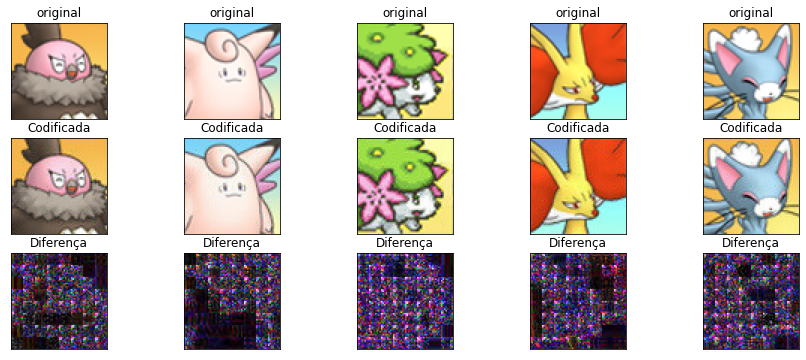

In [ ]:
n = 5
plt.figure(figsize=(15, 6))
for i in range(n):
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(dataset_imagens_originais[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i + 1 + n)
  plt.imshow(dataset_imagens_esteganografia[i])
  plt.title("Codificada")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
    
  ax = plt.subplot(3, n, i + 1 + n + n)
  plt.imshow(diff[i] * 10)
  plt.title("Diferença")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.savefig('dieferença_imagens.png')
plt.show()

In [ ]:
mseMedio = 0
psnrMedio = 0
ssimMedio = 0

mseVet = []
psnrVet = []
ssimVet = []

imagensComErroDeCodificacao = []

for i in range(dataset_imagens_originais.shape[0]):
  mse = mean_squared_error(dataset_imagens_originais[i], dataset_imagens_esteganografia[i])
  mseMedio += mse

  if mse >= 200:
    imagensComErroDeCodificacao.append(mse)
    continue

  mseVet.append(mse)

  psnr = peak_signal_to_noise_ratio(mse)
  psnrMedio += psnr
  psnrVet.append(psnr)

  ssim = structural_similarity(dataset_imagens_originais[i], dataset_imagens_esteganografia[i], multichannel=True)
  ssimMedio += ssim
  ssimVet.append(ssim)

mseMedio /= dataset_imagens_originais.shape[0]
psnrMedio /= dataset_imagens_originais.shape[0]
ssimMedio /= dataset_imagens_originais.shape[0]

print('Quantidade de imagens com erro de codificação: ', str(len(imagensComErroDeCodificacao)))

print()

print('MSE Médio:', mseMedio)
print('PSNR Médio:', psnrMedio)
print('SSIM Médio:', ssimMedio)

Quantidade de imagens com erro de codificação:  80

MSE Médio: 139.52315554533865
PSNR Médio: 26.485530382203454
SSIM Médio: 0.9836099160008195


In [ ]:
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
dataset_imagens_originais = (dataset_imagens_originais - 127.5) / 127.5
dataset_imagens_esteganografia = (dataset_imagens_esteganografia - 127.5) / 127.5

In [ ]:
dataset_imagens_originais_t = []
dataset_imagens_esteganografia_t = []

for idx, i in enumerate(dataset_imagens_originais):
  
  if idx in imagensComErroDeCodificacao:
    continue

  dataset_imagens_originais_t.append(i.T)

for idx, i in enumerate(dataset_imagens_esteganografia):

  if idx in imagensComErroDeCodificacao:
    continue

  dataset_imagens_esteganografia_t.append(i.T)

dataset_imagens_originais_t = np.array(dataset_imagens_originais_t)
dataset_imagens_esteganografia_t = np.array(dataset_imagens_esteganografia_t)

In [ ]:
alex = []
leng = len(dataset_imagens_originais_t)

for i in range(0, leng, 500):
  alex.append(loss_fn_alex(torch.from_numpy(dataset_imagens_originais_t[i:min(i+500, leng)]).float(), torch.from_numpy(dataset_imagens_esteganografia_t[i:min(i+500, leng)]).float()))

In [ ]:
vgg = []
leng = len(dataset_imagens_originais_t)

for i in range(0, leng, 500):
  vgg.append(loss_fn_vgg(torch.from_numpy(dataset_imagens_originais_t[i:min(i+500, leng)]).float(), torch.from_numpy(dataset_imagens_esteganografia_t[i:min(i+500, leng)]).float()))

In [ ]:
alexNp = []
vggNp = []

for i in alex:
  alexNp.append(i.cpu().detach().numpy())

for i in vgg:
  vggNp.append(i.cpu().detach().numpy())

In [ ]:
alexVet = []
vggVet = []

for i in range(len(alexNp)):
  for j in range(alexNp[i].shape[0]):
    alexVet.append(alexNp[i][j][0][0][0])
    vggVet.append(vggNp[i][j][0][0][0])

alexVet = np.array(alexVet)
vggVet = np.array(vggVet)

In [ ]:
print('Alex Médio:', alexVet.mean())
print('VGG Médio:', vggVet.mean())

Alex Médio: 0.005857221
VGG Médio: 0.09575837


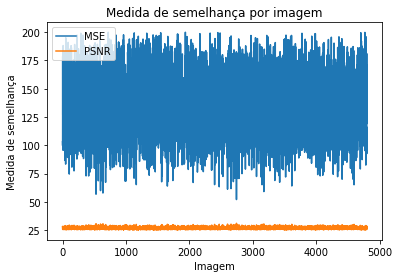

In [ ]:
legend = []

plt.plot(mseVet)
legend.append('MSE')
plt.plot(psnrVet)
legend.append('PSNR')
plt.title('Medida de semelhança por imagem')
plt.ylabel('Medida de semelhança')
plt.xlabel('Imagem')
plt.legend(legend, loc='upper left')
plt.savefig('medida_de_semelhança_por_imagem_1.png')
plt.show()

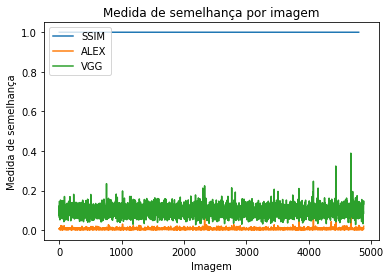

In [ ]:
legend = []

plt.plot(ssimVet)
legend.append('SSIM')
plt.plot(alexVet)
legend.append('ALEX')
plt.plot(vggVet)
legend.append('VGG')
plt.title('Medida de semelhança por imagem')
plt.ylabel('Medida de semelhança')
plt.xlabel('Imagem')
plt.legend(legend, loc='upper left')
plt.savefig('medida_de_semelhança_por_imagem_2.png')
plt.show()

In [ ]:
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

--- Execution time: 1091.1689505577087 seconds ---
